# Notebook used to estimate R_t patterns

In [1]:
import pandas as pd
from functools import reduce

In [2]:
df = pd.read_csv('data/world_r_eff.csv',
        usecols=['country','date','R'],
        parse_dates=['date'],
        squeeze=True
        ).sort_index()

In [3]:
trend_length = 14
logic_func = lambda r: reduce(lambda x, y: x + 1 if y else x * y, r)

In [4]:
countries = df.country.unique()
df_total = pd.DataFrame(columns=['country',	'date',	'R', 'increasing', 'decreasing', 'upward_slope', 'downward_slope', 'upward_slope_days', 'downward_slope_days' ])
for country in countries:
    df_country = df.loc[df['country'] == country]
    
    # counts number consecutive days with R>=1 for a give date
    ser = df_country['R'] >= 1
    df_country['increasing'] = ser.expanding().apply(logic_func)

    # counts number consecutive days with R<1 for a give date
    ser = df_country['R'] < 1
    df_country['decreasing'] = ser.expanding().apply(logic_func)

    # check if date is in a upward slope
    df_country['upward_slope'] = df_country['increasing'] >= trend_length

    # check if date is in a upward slope
    df_country['downward_slope'] = df_country['decreasing'] >= trend_length

    # counts number consecutive days with upward slope
    df_country['upward_slope_days'] = df_country['upward_slope'].expanding().apply(logic_func)

    # counts number consecutive days with downward_slope
    df_country['downward_slope_days'] = df_country['downward_slope'].expanding().apply(logic_func)
    
    # append df to total_df
    df_total = pd.concat([df_total, df_country])

length
<ipython-input-4-0cd51d1bbc82>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['downward_slope'] = df_country['decreasing'] >= trend_length
<ipython-input-4-0cd51d1bbc82>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['upward_slope_days'] = ser.expanding().apply(logic_func)
<ipython-input-4-0cd51d1bbc82>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [8]:
    # counts downward slopes and finds duration of them
    ser = df_country['downward_slope_days'] > 0
    count_down = df_country['downward_slope_days'] [ser & (ser != ser.shift(-1))].value_counts()
    len(count_down)

12

In [9]:
    # counts upward slopes and finds duration of them
    ser = df_country['upward_slope_days'] > 0
    count_up = df_country['upward_slope_days'] [ser & (ser != ser.shift(-1))].value_counts()
    len(count_up)

14

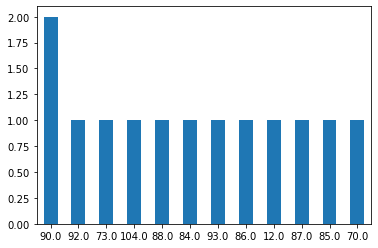

In [7]:
# plot upward periods
ax = count_up.plot.bar(x='lab', y='val', rot=0)